# Poiseuille - BGK - Zou-He Constant Velocity Inlet and Outlet

In [1]:
# Python Imports
from pylab import *
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors
from IPython.display import display, Math, Latex

## Setting Simulation

### Lattice Paremeters

In [2]:
w0=4.0/9.0;w1=1.0/9.0;w2=1.0/36.0; # Lattice Weights
w = np.array([w0,w1,w1,w1,w1,w2,w2,w2,w2],dtype="float64") 
cx = np.array([0,1,0,-1, 0,1,-1,-1, 1],dtype="int8")  # Lattice Directions
cy = np.array([0,0,1, 0,-1,1, 1,-1,-1],dtype="int8")  # Lattice Directions
opp = np.array([0,3,4,1,2,7,8,5,6],dtype="uint8")  # Opposite Lattice Directions

### Problem Scaling: From Dimensionless to LBM Scale

In [3]:
#------------Dimensionless Parameter For Pro----------------
uo = 1.0 # Dimensionless Velocity
ho = 1.0 # Dimensionless Domain Length
Re = 10.0 # Reynolds Number
nuo = uo*ho/Re #Dimensionless Kinematic Viscosity

The problem scaling follow the equations:
$$
\Delta x=\frac{H_{0}}{Nx}, \quad \quad r=\frac{\Delta x}{\Delta t}, \quad \quad u=u_{0}\frac{\Delta t}{\Delta x}, \quad \quad \textrm{and} \quad \quad \nu=\nu_{0}\frac{\Delta t}{\Delta x^{2}}
$$
where $\Delta x $ is grid size, $\Delta y$ is time step and $r$ is the relation term. Dimensionless numbers
$$
Re=\frac{u_{0}\rho H}{\mu}=\frac{u_{0} H}{\nu} \quad \quad \textrm{and} \quad \quad C_{d}=\frac{24}{Re}\frac{L}{H}.
$$
For the pressure drop inside the channel, the following was used:
$$
\Delta P = \frac{12\mu N_x U_m}{N_y^2}
$$

In [4]:
import time
#---------------Numerical Domain Size--------------------
cases=3
Nx0 = np.array([10, 20, 40],dtype="int64")
Ny0 = np.array([12, 22, 42],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")

mstep=10000
mstep0 = np.array([mstep*4**(0), mstep*4**(1), mstep*4**(2)],dtype="int64")
rhor = np.empty(len(Nx0), dtype=object)
Vxr = np.empty(len(Nx0), dtype=object)
Vyr = np.empty(len(Nx0), dtype=object)
Cdr = np.zeros((3),dtype="float64")
Mass = np.empty(len(Nx0), dtype=object)
for i in range(len(Nx0)):
    rhor[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Vxr[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Vyr[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
    Mass[i] = np.zeros((int(mstep0[i])), dtype="float64")
for case in range(0,cases):
    Nx=Nx0[case]
    Ny=Ny0[case]
    #------------------------------------------Scaling Term--------------------------------------------
    dx = ho / (Ny-2) # Grid size 
    r = r0[case] # Relation term r=dx/dt
    dt = dx / r # Time Step
    #----------------------------------------LBM-Scale-----------------------------------------------
    nu = dt * nuo / (dx * dx)  #Scaling Viscosity
    ue = dt * uo / dx  #Scaling Velocity
    cs = 1.0 / sqrt(3.) #Sound Speed
    tau = (nu/ (cs * cs)) + (1.0/ 2.0) #Relaxation time
    rhoi = 1.0 #Initial Densty

    #---------------Pressure input----------------
    Del_P = (12*nu*Nx*ue)/(Ny**2)
    #---------------------------------------------
    #--------------Print-Data-------------------------------------------------------------------------
    display(Math(r"\tau="+str(tau)+r"\quad\quad \nu="+str(nu)))
    display(Math(r"r="+str(r)+r"\quad\quad \overline{u}="+str(ue)))
    display(Math(r"dx="+str(dx)+r"\quad\quad dt="+str(dt)))
    #----------------Allocating array of solid nodes------------------------------------------------
    solid=np.ones((Nx,Ny),dtype="uint8") # Binary array to allocate the mapp of pore and solid # Parallel Plates
    solid[:,0] = 0
    solid[:,Ny-1] = 0
    #--------Allocating "imapp" array ti store the information of lattice directions that need be 
    # inverted during the Half-way Bounce-Back method.
    imapp=np.zeros((9,Nx,Ny),dtype="uint8") #Interface mapping for Half-Way Bounce-Back
    for i in range(0,Nx):
        for j in range (0, Ny):
            if (solid[i,j]==1):
                for k in range (0,9):
                    #-----------------------------------------
                    ii=i+cx[k] 
                    if (ii>Nx-1):ii=0
                    if (ii<0):ii=Nx-1
                    #-----------------------------------------
                    jj=j+cy[k] 
                    if (jj>Ny-1):jj=0
                    if (jj<0):jj=Ny-1
                    #-----------------------------------------
                    if (solid[ii,jj]==0):
                        imapp[k,i,j]=k
    #---------------------Field-Arrays---------------------------------------------------------------- 
    rho=np.zeros((Nx,Ny),dtype="float64") # Allocating Density field
    rho[:,:]=np.where(solid==1,rhoi,0.0) # Constant initial density field
    rhow=np.zeros((Ny),dtype="float64") # Allocating West Boundary Density
    rhoe=np.zeros((Ny),dtype="float64") # Allocating East Boundary Density
    up=np.zeros((Ny),dtype="float64") # Allocating Boundary Parabolic Profile
    y=np.linspace(0.5, Ny-2 -0.5, Ny-2)
    up[1:-1]=6.0 * ue * ( y/float(Ny - 2) - ( y/float(Ny - 2) )**2 );
    Vx=np.zeros((Nx,Ny),dtype="float64") # Allocating Null Velocity x Field
    Vy=np.zeros((Nx,Ny),dtype="float64") # Allocating Null Velocity y Field
    #----------------Initializing Distribution Functions----------------
    f=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pre-Collisional Distribution Function
    fp=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pos-Collisional Distribution Function
    feq=np.zeros((9,Nx,Ny),dtype="float64") # Allocating Pos-Collisional Distribution Function
    for k in range (0,9):
        f[k,:,:]=np.where(solid==1,w[k]*rho[:,:],0.0)
    #---------------------------------Main-Loop-------------------------------------------------------
    Cd=0.0; Cd0=0.0
    tolerance=0.000001
    start=time.time()
    #---------------------------------Main-Loop-------------------------------------------------------------------------------------
    for kk in range(0,mstep0[case]):
        #------------------------------------Collision-----------------------------------------------------------------------------
        for k in range(0,9):
            feq[k,:,:]=w[k]*rho*(1. + 3.*(Vx*cx[k]+Vy*cy[k]) + 4.5*(Vx*cx[k]+Vy*cy[k])**2-1.5*(Vx*Vx+Vy*Vy))
            fp[k,:,:]=np.where(solid==1, f[k,:,:]-(1.0/tau)*(f[k,:,:]-feq[k,:,:]), 0.0 )
        #----------------------------------Streaming---------------------------------------------------------------------------
        for k in range(0,9):
            f[k,:,:]=np.roll(np.roll(fp[k,:,:], cx[k], axis=0), cy[k], axis=1)
        #--------------------------------------Half-Way-------------------------------------------------------------------------
        for k in range(1,9):
            f[k,:,:]=np.where(imapp[opp[k],:,:]==opp[k],fp[opp[k],:,:],f[k,:,:])
        #--------------------------------------Zou-He-BC------------------------------------------------------------------------
        #--------------------Inlet------------------------------------------------------------
        for k in (1,5,8):
            f[k,0,:] = f[k,Nx-1,:] + w[k]*(Del_P/cs**2)
        #--------------------Outlet------------------------------------------------------------
        for k in (3,6,7):
            f[k,Nx-1,:] = f[k,0,:] - w[k]*(Del_P/cs**2)
        #--------------------------------------Macro-Properties------------------------------------------------------------------
        rho=np.where(solid==1,np.einsum('ixy->xy', f),0.0) 
        Vx=np.divide(np.einsum('i,ixy->xy', cx, f), rho, out=np.zeros_like(Vx, dtype="float64"), where=rho!=0)
        Vy=np.divide(np.einsum('i,ixy->xy', cy, f), rho, out=np.zeros_like(Vy, dtype="float64"), where=rho!=0)
        #-------------------------------------Convergence------------------------------------------------------------------------
        rho_med = np.sum(rho)/(Nx*(Ny-2))
        Mass[case][kk] = rho_med
        if (kk%1000==0):
            Umed = np.sum(Vx)/(Nx*(Ny-2))
            rho_med = np.sum(rho)/(Nx*(Ny-2))
            dp = (sum(rho[0,:]) - sum(rho[Nx-1,:]))*cs**2/(Ny-2)
            Cd=dp/(rho_med*Umed**2/2.0)
            print('Da=',Cd,'\t Diff=',np.fabs(Cd-Cd0),'\t Umed=',Umed,'\t Erro=',np.fabs(Cd-24.0/Re))
            # if(np.fabs(Cd-Cd0)<tolerance):
            #     break
            Cd0=Cd
    Cdr[case]=Cd
    rhor[case]=rho
    Vxr[case]=Vx
    Vyr[case]=Vy

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 5119.565981420356 	 Diff= 5119.565981420356 	 Umed= 0.0013021385251585707 	 Erro= 5117.165981420357
Da= 2.9071546517592717 	 Diff= 5116.6588267685975 	 Umed= 0.09626645517882892 	 Erro= 0.5071546517592718
Da= 2.907133058656929 	 Diff= 2.1593102342620796e-05 	 Umed= 0.09626682626944301 	 Erro= 0.5071330586569291
Da= 2.907133058537967 	 Diff= 1.1896217344542492e-10 	 Umed= 0.09626682627146853 	 Erro= 0.507133058537967
Da= 2.9071330585104747 	 Diff= 2.7492230714187826e-11 	 Umed= 0.09626682627192688 	 Erro= 0.5071330585104747
Da= 2.9071330584890567 	 Diff= 2.141797850185867e-11 	 Umed= 0.09626682627228465 	 Erro= 0.5071330584890568
Da= 2.9071330584723722 	 Diff= 1.6684431614066852e-11 	 Umed= 0.09626682627256425 	 Erro= 0.5071330584723723
Da= 2.9071330584593453 	 Diff= 1.3026912881741737e-11 	 Umed= 0.09626682627278288 	 Erro= 0.5071330584593454
Da= 2.9071330584491775 	 Diff= 1.0167866548727034e-11 	 Umed= 0.09626682627295438 	 Erro= 0.5071330584491776
Da= 2.907133058441225 	 Diff= 7.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 68835.03902760663 	 Diff= 68835.03902760663 	 Umed= 0.00019369907384795572 	 Erro= 68832.63902760664
Da= 2.901945310745284 	 Diff= 68832.13708229589 	 Umed= 0.05192369412352825 	 Erro= 0.5019453107452843
Da= 2.6602266674797033 	 Diff= 0.2417186432655809 	 Umed= 0.05425650859412298 	 Erro= 0.26022666747970336
Da= 2.6499560401577797 	 Diff= 0.01027062732192352 	 Umed= 0.054362723213993006 	 Erro= 0.24995604015777984
Da= 2.649489852220475 	 Diff= 0.0004661879373046851 	 Umed= 0.054367559154859066 	 Erro= 0.24948985222047515
Da= 2.6494686297091925 	 Diff= 2.1222511282559253e-05 	 Umed= 0.0543677793345878 	 Erro= 0.2494686297091926
Da= 2.649467663457217 	 Diff= 9.662519753206311e-07 	 Umed= 0.054367789359343936 	 Erro= 0.24946766345721727
Da= 2.6494676194636657 	 Diff= 4.399355146844641e-08 	 Umed= 0.05436778981577313 	 Erro= 0.2494676194636658
Da= 2.6494676174605094 	 Diff= 2.0031563074951464e-09 	 Umed= 0.05436778983655771 	 Erro= 0.2494676174605095
Da= 2.64946761736907 	 Diff= 9.1439

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Da= 1003519.43310658 	 Diff= 1003519.43310658 	 Umed= 2.6573136757349244e-05 	 Erro= 1003517.03310658
Da= 8.503785067696917 	 Diff= 1003510.9293215123 	 Umed= 0.01581798303633304 	 Erro= 6.103785067696917
Da= 4.045994922186955 	 Diff= 4.457790145509962 	 Umed= 0.022943643240125634 	 Erro= 1.6459949221869548
Da= 3.0954757196946887 	 Diff= 0.950519202492266 	 Umed= 0.02623856234396097 	 Erro= 0.6954757196946888
Da= 2.765862829598657 	 Diff= 0.32961289009603156 	 Umed= 0.027762203189903936 	 Erro= 0.36586282959865724
Da= 2.6310276462545605 	 Diff= 0.1348351833440966 	 Umed= 0.028466765336222114 	 Erro= 0.23102764625456063
Da= 2.5719977825051106 	 Diff= 0.05902986374944996 	 Umed= 0.028792568618625624 	 Erro= 0.17199778250511066
Da= 2.5453728501497945 	 Diff= 0.026624932355316044 	 Umed= 0.028943226324336897 	 Erro= 0.14537285014979462
Da= 2.533200988689736 	 Diff= 0.01217186146005833 	 Umed= 0.02901289332693844 	 Erro= 0.1332009886897363
Da= 2.5276020811587863 	 Diff= 0.005598907530949937

Text(0, 0.5, '$Y$')

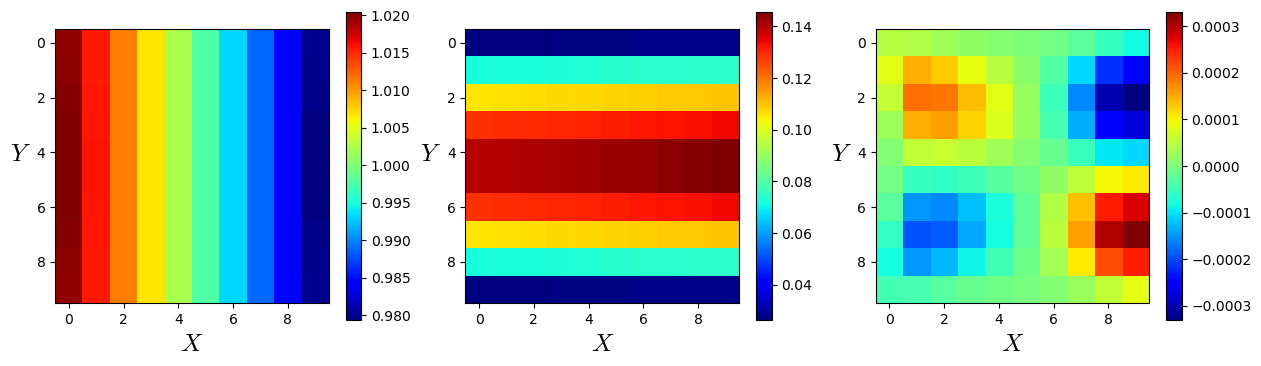

In [5]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
fig1, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(15,4))
img1=ax1.imshow(np.rot90(rhor[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img1, ax=ax1)
ax1.set_xlabel('$X$',fontsize=18)
ax1.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0)
img2=ax2.imshow(np.rot90(Vxr[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img2, ax=ax2)
ax2.set_xlabel('$X$',fontsize=18)
ax2.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 
img3=ax3.imshow(np.rot90(Vyr[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img3, ax=ax3)
ax3.set_xlabel('$X$',fontsize=18)
ax3.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 

In [6]:
Nx0 = np.array([10, 20, 40],dtype="int64")
Ny0 = np.array([12, 22, 42],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")
Vxana = np.empty(len(Nx0), dtype=object)
for i in range(len(Nx0)):
    Vxana[i] = np.zeros((int(Nx0[i]), int(Ny0[i])), dtype="float64")
for i in range(len(Nx0)):
    y=np.linspace(0.5, Ny0[i]-2 -0.5, Ny0[i]-2) / float(Ny0[i] - 2)
    for ix in range(Nx0[i]):
        Vxana[i][ix,1:-1]=6.0 * (1.0/r0[i]) * ( y - ( y )**2 );

Text(0, 0.5, '$Y$')

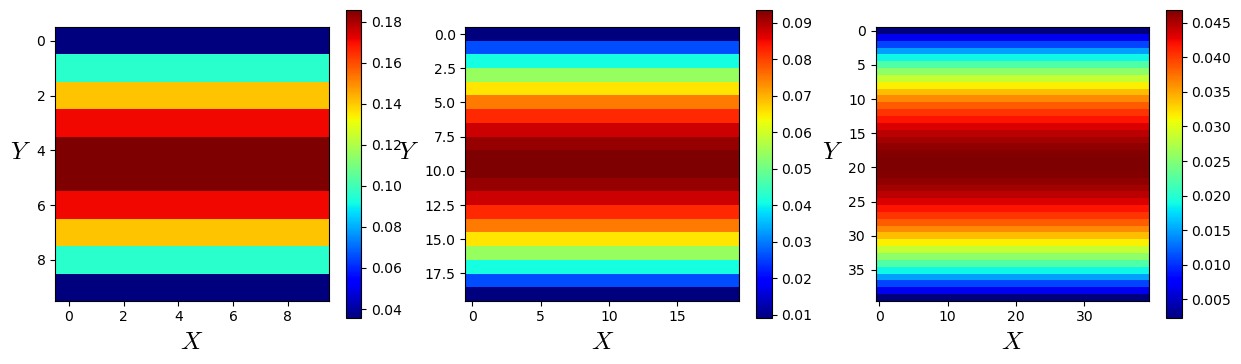

In [7]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
fig1, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(15,4))
img1=ax1.imshow(np.rot90(Vxana[0][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img1, ax=ax1)
ax1.set_xlabel('$X$',fontsize=18)
ax1.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0)
img2=ax2.imshow(np.rot90(Vxana[1][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img2, ax=ax2)
ax2.set_xlabel('$X$',fontsize=18)
ax2.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 
img3=ax3.imshow(np.rot90(Vxana[2][:,1:-1]),cmap='jet', interpolation='none')
fig1.colorbar(img3, ax=ax3)
ax3.set_xlabel('$X$',fontsize=18)
ax3.set_ylabel('$Y$',fontsize=18,horizontalalignment='right',rotation=0) 

In [8]:
E0=sqrt(sum((Vxr[0][:,:]-Vxana[0][:,:])**2))/sqrt(sum((Vxana[0][:,:])**2))
E1=sqrt(sum((Vxr[1][:,:]-Vxana[1][:,:])**2))/sqrt(sum((Vxana[1][:,:])**2))
E2=sqrt(sum((Vxr[2][:,:]-Vxana[2][:,:])**2))/sqrt(sum((Vxana[2][:,:])**2))

<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_25853/2330196724.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta x$',fontsize=16)


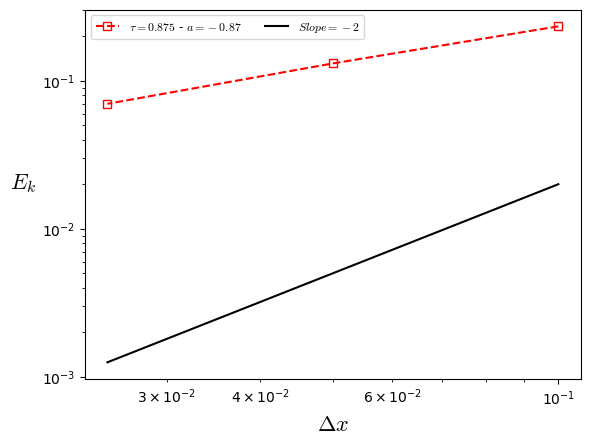

In [9]:
Malha=np.array([10,20,40])
Ek = np.array([E0,E1,E2])
TEk=np.polyfit(np.log(Malha), np.log(Ek), 1)
# Ek1 = np.array([0.000885053175400552,0.0002657329674660147,7.199195200913167e-05,1.8693115438450647e-05])
# TEk1=np.polyfit(np.log(Malha), np.log(Ek1), 1)
plt.loglog(1/Malha,Ek,'rs--',fillstyle='none')
# plt.loglog(1/Malha,Ek1,'bs--',fillstyle='none')
plt.loglog(1/Malha,2.0*1.0/(Malha**2),'k-',fillstyle='none')
plt.ylabel('$E_{k}$',fontsize=16,rotation=0,horizontalalignment='right')
plt.xlabel('$\Delta x$',fontsize=16)
plt.legend([fr'$\tau=0.875$ - $a={TEk[0]:.2f}$','$Slope=-2$'],loc=2,ncol=3,fontsize=8.5)

<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_25853/3738057210.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\overline{M}$',fontsize=16,rotation=0,horizontalalignment='right')


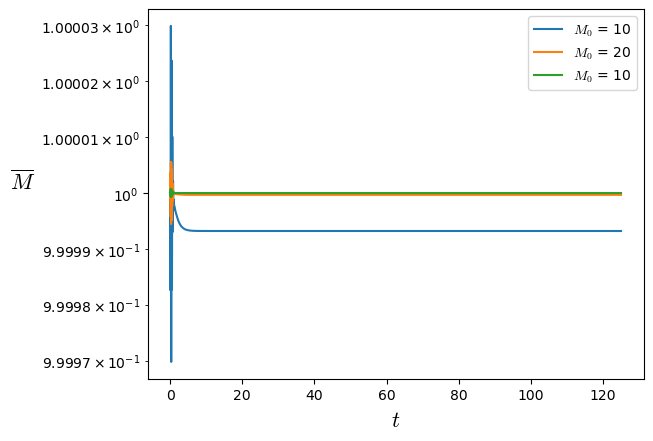

In [10]:
Nx0 = np.array([10, 20, 40],dtype="int64")
r0 = np.array([2.0**(3), 2.0**(4), 2.0**(5)],dtype="float64")
plt.semilogy(np.linspace(0,len(Mass[0]),len(Mass[0]))/Nx0[0]/r0[0],Mass[0],label=f'$M_0$ = {Nx0[0]}')
plt.semilogy(np.linspace(0,len(Mass[1]),len(Mass[1]))/Nx0[1]/r0[1],Mass[1],label=f'$M_0$ = {Nx0[1]}')
plt.semilogy(np.linspace(0,len(Mass[2]),len(Mass[2]))/Nx0[2]/r0[2],Mass[2],label=f'$M_0$ = {Nx0[0]}')
plt.ylabel('$\overline{M}$',fontsize=16,rotation=0,horizontalalignment='right')
plt.xlabel('$t$',fontsize=16)
plt.legend()